## Getting data

In [1]:
import os
from tqdm import tqdm
from copy import deepcopy
from datetime import datetime
from argparse import Namespace

import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import cv2

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, balanced_accuracy_score
import torch
from torch.utils.data import Dataset
from torchvision import models, transforms
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [2]:
!mkdir 102flowers | wget -c https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz -O - | tar -xz -C 102flowers
#!mkdir 102segmentations | wget -c https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102segmentations.tgz -O - | tar -xz -C 102segmentations
#!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/distancematrices102.mat
!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat
#!wget https://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat


mkdir: cannot create directory ‘102flowers’: File exists
--2023-08-31 21:30:48--  https://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/flowers-102/102flowers.tgz [following]
--2023-08-31 21:30:49--  https://thor.robots.ox.ac.uk/datasets/flowers-102/102flowers.tgz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/octet-stream]
Saving to: ‘STDOUT’

-                   100%[===================>] 328.89M  20.3MB/s    in 17s     

2023-08-31 21:31:07 (19.1 MB/s) - written to stdout [344862509/344862509]

--2023-08-31 21:31:07-- 

In [3]:
labels = scipy.io.loadmat('imagelabels.mat')['labels'][0]
print(len(labels))

8189


In [4]:
n = len(labels)
filepath = [f"image_{i:05d}.jpg" for i in range(1, n+1)]
df = pd.DataFrame(data={'filepath':filepath, 'label':labels})
df.to_csv('full.csv', index=False)

## Utils

In [5]:
def display_examples(images, labels, num_images=25):
    """
        Display images from a array of images with its corresponding labels.
    """
    fig = plt.figure(figsize=(10,10))

    for i in range(min(num_images, len(images))):
        plt.subplot(num_images//5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(labels[i])
    plt.show()

In [6]:
def imshow(images, labels, num_images=25, compare=False):
    """
        Display image from list of tensors with its corresponding labels.
    """
    if compare:
        fig = plt.figure(figsize=(20,10))
    else:
        fig = plt.figure(figsize=(10,10))
    plt.grid(False)

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for i in range(min(num_images, len(images))):
        plt.subplot(num_images//5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel(labels[i])#.item())

        image = images[i].numpy().transpose((1, 2, 0))
        image = std * image + mean
        image = np.clip(image, 0, 1)
        plt.imshow(image, cmap=plt.cm.binary)

    plt.show()

In [7]:
def print_predicted_class(dataloader, model, device, correct=False, compare=False):
    """
        Show examples of images by the classifier with the predicted class
    """
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)
    logits = model(images)
    _, preds = torch.max(logits, 1)

    BOO = (labels == preds).cpu()
    mislabeled_indices = np.where(BOO == int(correct))
    mislabeled_images = images[mislabeled_indices]
    mislabeled_labels = preds[mislabeled_indices]

    if compare:
        original_labels = labels[mislabeled_indices]
        concat_images = []
        concat_labels = []
        for i in range(len(mislabeled_labels)):
            pred_label = mislabeled_labels[i]
            class_image, class_label = dataloader.dataset.get_class_sample(pred_label.item())
            concat_images.append(torch.cat((mislabeled_images[i].cpu(), class_image[0]), 2).cpu())
            concat_labels.append("true: {}  pred: {}".format(original_labels[i].item(), class_label[0]))
        imshow(concat_images, concat_labels, compare=True)

    else:
        imshow(mislabeled_images.cpu(), mislabeled_labels.cpu())

In [8]:
def save_model(epochs, model, optimizer, criterion, filename="resnet50_flower.pth"):
    """
       Save the trained model to disk.
    """
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, './models/'+filename)

In [9]:
def plot_acc_loss(train_acc, valid_acc, train_loss, valid_loss, outfig=False):
    """
        Plot traning and validation accuracy and loss curve
    """

    fig = plt.figure(figsize=(15,5))

    # accuracy plots
    #plt.figure(figsize=(5, 3.5))
    plt.subplot(1,2,1)
    plt.plot(
        train_acc, color='green', linestyle='-',
        label='train acc'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-',
        label='valid acc'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    if outfig:
        plt.savefig('accuracy.png')

    # loss plots
    plt.subplot(1,2,2)
    plt.plot(
        train_loss, color='orange', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-',
        label='valid loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    if outfig:
        plt.savefig('loss.png')

    plt.show()

## EDA

Variation of image (i.e. size, resolution, lighting,background)

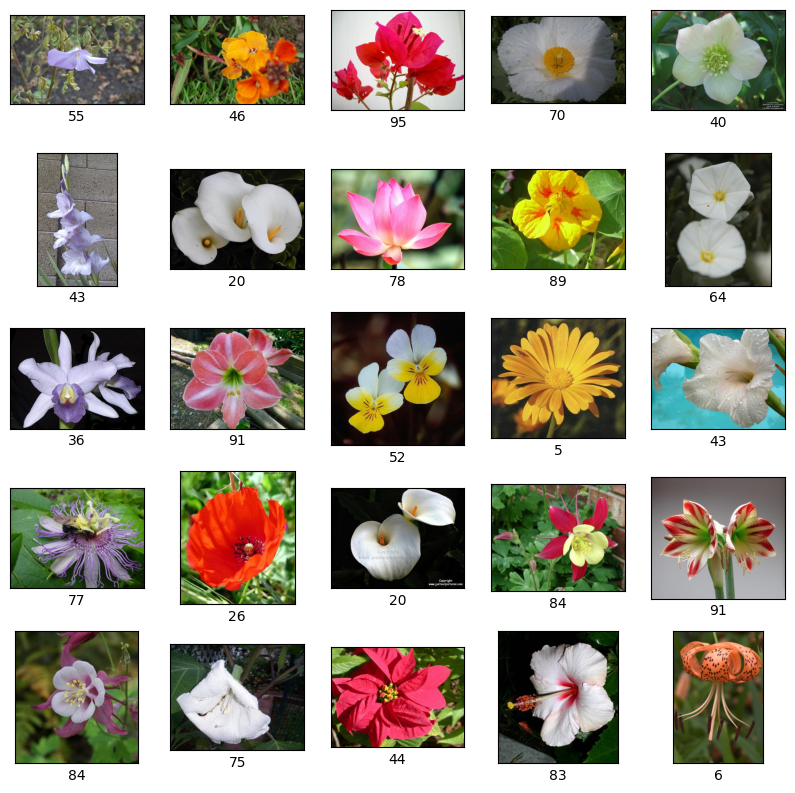

In [10]:
img_dir = "102flowers/jpg/"
num_images=25
randi = np.random.randint(0,len(df), num_images)
images, targets = [],[]
for i in range(num_images):
    img_path = os.path.join(img_dir, df.iloc[randi[i], 0])
    im_pil = Image.open(img_path)
    images.append(im_pil)
    targets.append(df.iloc[randi[i], 1])

display_examples(images, targets, 25)

Orginal label index is starting at 1, later will apply -1 to all label to match with the model output

In [11]:
df.label.unique()

array([ 77,  73,  88,  89,  81,  46,  74,  51,  44,  82,  83,  78,  80,
        75,  41,  43,  76,  84,  58,  56,  86,  60,  92,  11,  65,   8,
        23,  30,  72,  53,  37,  17,  12,  29,  52,  18,  36,  90,  71,
        40,  48,  55,  85,  91,  20,  47,  59,   2,   5,  28,  70,  22,
        54,  87,  66,  32,   4,  42,  13,  38,  63,  68,  69,  93,  14,
        64,  19,  49,  61,  50,  15,   9,  33,  26,  25,   3,  16,  79,
         1,  21,  24,  27,  31,  34,  35,  39,  67,  10,  45,   6,   7,
        57,  62,  94,  95,  96,  97,  98,  99, 100, 101, 102], dtype=uint8)

Distribution of class

<Axes: >

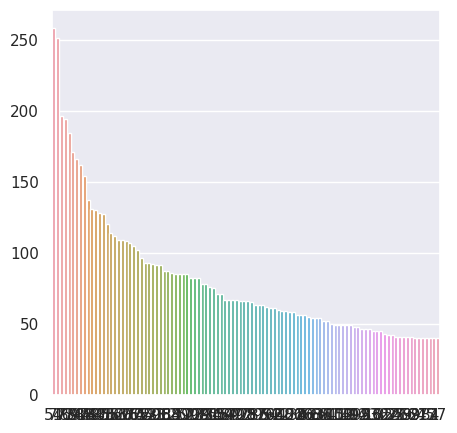

In [12]:
target_counts=df.label.value_counts().sort_values(ascending=False)
sns.set(rc={"figure.figsize":(5, 5)})
sns.barplot(y=target_counts.values, x=target_counts.index.values, order=target_counts.index)

## Define Dataset

In [13]:
class CustomImageDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, n_class=102):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.n_class = n_class
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        im_pil = Image.open(img_path)
        if self.transform:
            image = self.transform(im_pil)

        label = self.df.iloc[idx, 1]

        return image, label

    def get_class_sample(self, class_name, n=1):
        images, labels = [], []
        samples = self.df[self.df.iloc[:,1] == class_name].sample(n=n)
        for i in range(n):
            img_path = os.path.join(self.root_dir, samples.iloc[i,0])
            im_pil = Image.open(img_path)
            if self.transform:
                image = self.transform(im_pil)
            images.append(image)
            labels.append(samples.iloc[i,1])

        return images, labels

In [14]:
def build_dataloader(csv, batch_size, shuffle,
                     transform=None,
                     img_dir="102flowers/jpg/",
                     num_workers=4):

    # mean and standard deviation of the ImageNet images
    # Used in transfered learning
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])

    resnet_transform = [transforms.Resize((224,224)),
                        transforms.ToTensor(),
                        normalize]

    if transform:
        resnet_transform = resnet_transform[:1]+transform+resnet_transform[1:]

    data_transform =  transforms.Compose(resnet_transform)
    image_dataset = CustomImageDataset(csv, img_dir, transform=data_transform)

    dataloader = torch.utils.data.DataLoader(
        image_dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers)

    return dataloader

Testing dataloader

Feature batch shape: torch.Size([10, 3, 224, 224])
Labels batch shape: torch.Size([10])


<ipython-input-6-2c532db30a43>:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(num_images//5,5,i+1)


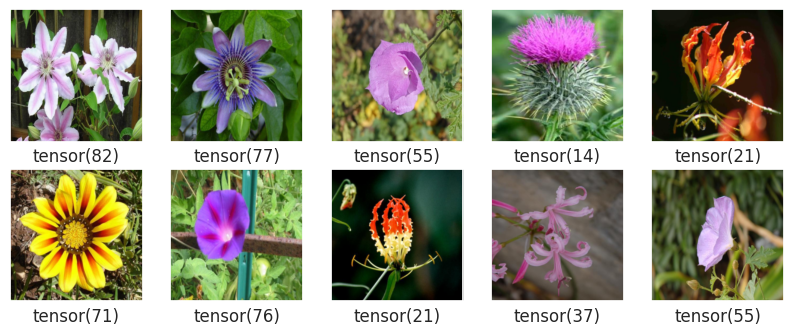

In [15]:
dataloader = build_dataloader(csv="full.csv", batch_size=10, shuffle=True, num_workers=0)
inputs, targets = next(iter(dataloader))
print(f"Feature batch shape: {inputs.size()}")
print(f"Labels batch shape: {targets.size()}")

imshow(inputs, targets)

## Define Resnet-50

In [16]:
def get_resnet50(freeze=True, weights=ResNet50_Weights.IMAGENET1K_V2, hidden=256, n_class=102):
    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

    if freeze:
        for param in model.parameters():
            param.requires_grad = False

    model.fc = nn.Sequential(
                nn.Linear(2048, hidden),
                nn.ReLU(inplace=True),
                nn.Linear(hidden, n_class))
    # The CrossEntropyLoss function in PyTorch combines the softmax function
    # with the cross entropy calculation,
    # so no need any activation function at the output layer of your model.

    return model

In [17]:
def build_optimizer(model, optimizer, learning_rate, weight_decay):
    if optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    elif optimizer == "adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer == "adamW":
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    return optimizer

In [18]:
def build_scheduler(optimizer, scheduler, gamma):
    if scheduler == "None":
        scheduler = None
    else:
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3, 6, 12, 18], gamma=gamma)

    return scheduler

In [19]:
def build_criterion(criterion, device, dataloader):
    if criterion == "cross_entropy":
        criterion = nn.CrossEntropyLoss()
    elif criterion == "weighted_cross_entropy":
        weight = compute_class_weight('balanced',
                         classes=[i for i in range(dataloader.dataset.n_class)],
                         y=dataloader.dataset.df.iloc[:,1])
        weight = torch.tensor(weight).float().to(device)
        criterion = nn.CrossEntropyLoss(weight)
    return criterion

In [20]:
def train(model, optimizer, criterion, train_loader, device, scheduler):
    print('Training')
    t = tqdm(enumerate(train_loader), desc='Loss: **** | Acc: ****%',
             total=len(train_loader),
             bar_format='{desc}{bar}{r_bar}')

    model.train()
    train_loss, correct, total = 0.0, 0, 0
    for batch_idx, (inputs, targets) in t:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        logits = model(inputs)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(logits, 1)
        correct += (preds == targets).sum().item()
        train_loss += loss.item() * logits.size(0)
        total += targets.size(0)

        t.set_description('Loss: %.3f | Acc: %.3f%%' % (
                            train_loss / total,
                            100. * correct / total))

    if scheduler:
        scheduler.step()


    epoch_loss = train_loss / total
    epoch_acc = 100. * (correct / total)

    return epoch_loss, epoch_acc

In [21]:
def eval(model, criterion, test_loader, device):
    print('Validation')
    t = tqdm(enumerate(test_loader), desc='Loss: **** | Test Acc: ****%',
                 total=len(test_loader),
                 bar_format='{desc}{bar}{r_bar}')

    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    y_true, y_pred = torch.tensor([]), torch.tensor([])

    with torch.no_grad():
        for batch_idx, (inputs, targets) in t:
            inputs, targets = inputs.to(device), targets.to(device)
            logits = model(inputs)
            loss = criterion(logits, targets)

            _, preds = torch.max(logits, 1)
            correct += (preds == targets).sum().item()
            test_loss += loss.item() * logits.size(0)
            total += targets.size(0)
            y_true = torch.cat((y_true, targets.cpu()))
            y_pred = torch.cat((y_pred, preds.cpu()))

            t.set_description('Loss: %.3f | Acc: %.3f%%'
                              % (test_loss / total,
                                 100. * correct / total))

    epoch_loss = test_loss / total
    epoch_acc = 100. * balanced_accuracy_score(y_true, y_pred)

    return epoch_loss, epoch_acc

In [22]:
def test(model, criterion, test_loader, device):
    print('Testing')
    t = tqdm(enumerate(test_loader), desc='Loss: **** | Test Acc: ****%',
                 total=len(test_loader),
                 bar_format='{desc}{bar}{r_bar}')

    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    y_true, y_pred = torch.tensor([]), torch.tensor([])

    with torch.no_grad():
        for batch_idx, (inputs, targets) in t:
            inputs, targets = inputs.to(device), targets.to(device)
            logits = model(inputs)
            loss = criterion(logits, targets)

            _, preds = torch.max(logits, 1)
            correct += (preds == targets).sum().item()
            test_loss += loss.item() * logits.size(0)
            total += targets.size(0)
            y_true = torch.cat((y_true, targets.cpu()))
            y_pred = torch.cat((y_pred, preds.cpu()))

            t.set_description('Loss: %.3f | Acc: %.3f%%'
                              % (test_loss / total,
                                 100. * correct / total))

    precision, recall, f1_score,_ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    cmat = confusion_matrix(y_true, y_pred, normalize='true')

    epoch_loss = test_loss / total
    epoch_acc = 100. * balanced_accuracy_score(y_true, y_pred)

    return epoch_loss, epoch_acc, (precision, recall, f1_score, cmat), (y_true, y_pred)

## Finetuning Resnet50

In [23]:
def main(config):
    if not os.path.exists('./models/'):
        os.makedirs('./models/')

    train_dataloader = build_dataloader("train.csv", config.batch_size, shuffle=True, num_workers=config.num_workers)
    valid_dataloader = build_dataloader("valid.csv", config.batch_size, shuffle=False, num_workers=config.num_workers)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    model = get_resnet50(hidden=config.hidden)
    model.to(device)

    torch.manual_seed(13)
    criterion = build_criterion(config.criterion, device, train_dataloader)
    optimizer = build_optimizer(model, config.optimizer, config.lr, config.weight_decay)
    scheduler = build_scheduler(optimizer, config.scheduler, config.gamma)

    best_acc = 0
    train_loss, valid_loss = [], []
    train_acc, valid_acc = [], []

    for epoch in range(config.num_epochs):
        print(f"[INFO]: Epoch {epoch+1} of {config.num_epochs}")

        train_epoch_loss, train_epoch_acc = train(model, optimizer, criterion, train_dataloader, device, scheduler=scheduler)
        valid_epoch_loss, valid_epoch_acc = eval(model, criterion, valid_dataloader, device)

        train_loss.append(train_epoch_loss)
        valid_loss.append(valid_epoch_loss)
        train_acc.append(train_epoch_acc)
        valid_acc.append(valid_epoch_acc)
        print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
        print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
        print('-'*50)

        if valid_epoch_acc > best_acc:
            save_model(config.num_epochs, model, optimizer, criterion, filename=config.filename)
            best_acc = valid_epoch_acc

    return train_acc, valid_acc, train_loss, valid_loss

In [24]:
full_df = pd.read_csv("full.csv")
X_train_full, X_test, y_train_full, y_test = train_test_split(full_df.filepath.values, (full_df.label-1).values, test_size=0.2, shuffle=True)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.25, shuffle=True)

train_df = pd.DataFrame(data={'filepath':X_train, 'label':y_train})
train_df.to_csv('train.csv', index=False)
valid_df = pd.DataFrame(data={'filepath':X_valid, 'label':y_valid})
valid_df.to_csv('valid.csv', index=False)
test_df = pd.DataFrame(data={'filepath':X_test, 'label':y_test})
test_df.to_csv('test.csv', index=False)


Ensure label index is starting from 0

In [25]:
train_df.label.unique()

array([ 74,  23,  43,  94,  99,  81,  97,  76,  79,  45,  13,  29,   8,
        26,   5,  86,  73,  57,  92,   1,  78,  96,  24,  80,  87,  62,
        71,  40,  91,  65,   9,  60,  50,  59,  22,  41,  16,  72,  31,
        21,  77,  58,  64,   7,  51,  19,  88,  93,  28,  83,  84,   3,
        56,  49,  34,  67,  75,  27,  70,  35,  44, 100,  10,  47,  53,
        15,  42,  69,  36,  63,   2,  89,  82,  54,   0,  20,  85,  38,
        11,  61,  95,  12,  66,  90,  39,  98,  48,   4,  55,  18,  25,
        14,  68,  37,  52,  32,  46, 101,  30,  17,   6,  33])

In [26]:
config = Namespace()

config.num_workers = 4  # 2 for kaggle notebook, 4 for colab
config.batch_size = 32
config.num_epochs = 10

config.hidden = 256

config.criterion = "cross_entropy"

config.optimizer = 'adam'
config.lr = 0.001
config.weight_decay = 1e-5

config.scheduler = 'None'
config.gamma = 0.1

config.filename = "baseline_best.pth"

In [ ]:
train_acc, valid_acc, train_loss, valid_loss = main(config)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


cuda:0
[INFO]: Epoch 1 of 10
Training


Loss: 2.924 | Acc: 40.953%: ██████████| 154/154 [00:30<00:00,  5.11it/s]

Validation



Loss: 1.326 | Acc: 75.397%: ██████████| 52/52 [00:08<00:00,  5.94it/s]


Training loss: 2.924, training acc: 40.953
Validation loss: 1.326, validation acc: 68.523
--------------------------------------------------
[INFO]: Epoch 2 of 10
Training


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss: 0.855 | Acc: 83.533%: ██████████| 154/154 [00:28<00:00,  5.49it/s]

Validation



Loss: 0.612 | Acc: 87.851%: ██████████| 52/52 [00:08<00:00,  5.99it/s]


Training loss: 0.855, training acc: 83.533
Validation loss: 0.612, validation acc: 84.902
--------------------------------------------------
[INFO]: Epoch 3 of 10
Training


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss: 0.382 | Acc: 93.405%: ██████████| 154/154 [00:31<00:00,  4.96it/s]

Validation



Loss: 0.470 | Acc: 89.255%: ██████████| 52/52 [00:08<00:00,  5.98it/s]


Training loss: 0.382, training acc: 93.405
Validation loss: 0.470, validation acc: 86.279
--------------------------------------------------
[INFO]: Epoch 4 of 10
Training


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss: 0.213 | Acc: 96.703%: ██████████| 154/154 [00:29<00:00,  5.20it/s]

Validation



Loss: 0.353 | Acc: 91.026%: ██████████| 52/52 [00:08<00:00,  5.89it/s]


Training loss: 0.213, training acc: 96.703
Validation loss: 0.353, validation acc: 89.487
--------------------------------------------------
[INFO]: Epoch 5 of 10
Training


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss: 0.127 | Acc: 98.596%: ██████████| 154/154 [00:28<00:00,  5.49it/s]

Validation



Loss: 0.310 | Acc: 92.674%: ██████████| 52/52 [00:09<00:00,  5.68it/s]


Training loss: 0.127, training acc: 98.596
Validation loss: 0.310, validation acc: 91.265
--------------------------------------------------
[INFO]: Epoch 6 of 10
Training


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss: 0.071 | Acc: 99.449%: █         | 16/154 [00:04<00:28,  4.91it/s]

In [ ]:
plot_acc_loss(train_acc, valid_acc, train_loss, valid_loss)

- Model stop learning after the 4 epochs
- Overfitting

### Error analysis

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = get_resnet50(config.hidden)
model.load_state_dict(torch.load('models/'+config.filename, map_location=device)['model_state_dict'])
model = model.to(device)
model.eval()

test_dataloader = build_dataloader("test.csv", 256, shuffle=False)

#### Compare image to the sample from the misclassified class
Usually have similar color



In [ ]:
print_predicted_class(test_dataloader, model, device, compare=True)

In [ ]:
criterion = nn.CrossEntropyLoss()
test_epoch_loss, test_epoch_acc, metrics, result = test(model, criterion , test_dataloader, device)

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap(metrics[3],
            #annot=True,
            #fmt=".1f",
            xticklabels=102,
            yticklabels=102)
plt.title('Confusion matrix')
plt.show()

#### Analysis classes with low/high class accuracy

In [ ]:
cmat = metrics[3]
class_acc = [cmat[i][i] for i in range(len(cmat))]
acc_arr = np.array(class_acc)
low_acc = np.argwhere(acc_arr < 0.67).squeeze()

for idx in low_acc:
    idxs = np.argwhere(cmat[idx] > 0)
    vals = np.around(cmat[idx][np.argwhere(cmat[idx] > 0)], decimals=2)
    print(idx, np.round(acc_arr[idx],2), dict((v,k) for v,k in zip(idxs.squeeze(),vals.squeeze())))

In [ ]:
# image with low class accuracy
images, labels = [], []
for i in low_acc.squeeze():
    img, label = test_dataloader.dataset.get_class_sample(i, n=5)
    images = images+img
    labels = labels+label
imshow(images, labels)

- Have variation of colors during different stage
- Photo taken from different angel

In [ ]:
# image with high class accuracy
high_acc = np.argwhere(acc_arr > 0.99).squeeze()
images, labels = [], []
for i in np.random.choice(high_acc, size=5):
    img, label = test_dataloader.dataset.get_class_sample(i, n=5)
    images = images+img
    labels = labels+label
imshow(images, labels)

## Resnet50 - imbalence dataset

In [ ]:
config = Namespace()

config.num_workers = 4  # 2 for kaggle notebook, 4 for colab
config.batch_size = 32
config.num_epochs = 10

config.hidden = 256

config.criterion = "weighted_cross_entropy"

config.optimizer = 'adam'
config.lr = 0.001
config.weight_decay = 1e-5

config.scheduler = 'None'
config.gamma = 0.1

config.filename = "balanced_best.pth"

In [ ]:
train_acc, valid_acc, train_loss, valid_loss = main(config)

In [ ]:
plot_acc_loss(train_acc, valid_acc, train_loss, valid_loss)

### Error analysis

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = get_resnet50(config.hidden)
model.load_state_dict(torch.load('models/'+config.filename, map_location=device)['model_state_dict'])
model = model.to(device)
model.eval()

test_dataloader = build_dataloader("test.csv", 256, shuffle=False)

In [ ]:
criterion = nn.CrossEntropyLoss()
test_epoch_loss, test_epoch_acc, metrics, result = test(model, criterion , test_dataloader, device)

In [ ]:
# Find classes with low accuracy (acc < 0.7) and their predictions
cmat = metrics[3]
class_acc = [cmat[i][i] for i in range(len(cmat))]
acc_arr = np.array(class_acc)
low_acc = np.argwhere(acc_arr < 0.7).squeeze()

for idx in low_acc:
    idxs = np.argwhere(cmat[idx] > 0)
    vals = np.around(cmat[idx][np.argwhere(cmat[idx] > 0)], decimals=2)
    print(idx, np.round(acc_arr[idx],2), dict((v,k) for v,k in zip(idxs.squeeze(),vals.squeeze())))